In [1]:
%%capture
!pip install yfinance

# Predicting the Markets with Naive Machine Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance
    
import yfinance as yf

start_date = '2010-01-01'
end_date = '2021-12-31'
ticker='AMZN'
df=yf.download(ticker, start_date, end_date)


module 'yfinance' is installed
[*********************100%***********************]  1 of 1 completed


In [3]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800


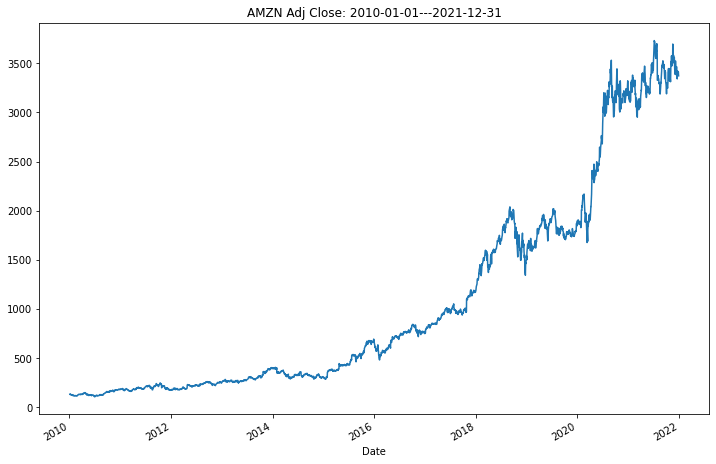

In [4]:
df['Adj Close'].plot(title=f'{ticker} Adj Close: {start_date}---{end_date}', figsize=(12,8))

## Create the response variable and split the data into training (80%) & test (20%)

### If we model the response variable as future price-current price, then we are trying to predict the direction of the future price with regard to the current price 

### If we try to predict one of the two signals
- the direction, we can use +1 to signify the future price moving up, -1 moving down, and remains the same as the current price.
- the price change

In [5]:
#Direction
def create_classification_trading_condition(data):
    data['Open-Close']=data.Open-data.Close         # price change during the day
    data['High-Low']=data.High-data.Low             # difference between the high and the low during the day
    data=data.dropna()
    X=data[['Open-Close', 'High-Low']]
    Y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)   #target: direction of he price change
    return (data, X, Y)

In [6]:
#Price change
def create_regression_trading_condition(data):
    data['Open-Close']=data.Open-data.Close
    data['High-Low']=data.High-data.Low
    data['Target']=data['Close'].shift(-1)-data['Close']  #price increase for he next day
    data=data.dropna()
    X=data[['Open-Close',  'High-Low']]
    Y = data['Target'] 
    return (data, X, Y)

In [7]:
from sklearn.model_selection import train_test_split
def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

### For illustration, we use price change as the target variable

In [8]:
df,X,Y=create_regression_trading_condition(df)
df.head(5)

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,Target
Date,,,,,,,,,
2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900,2.350006,3.470001,0.790009
2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900,-1.260010,3.669998,-2.440002
2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800,2.350006,3.080002,-2.250000
2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200,2.009995,3.520004,3.520004
2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500,-2.960007,4.649994,-3.210007


## Do H-L and O-C have impact on next days price change?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f57c2b204d0>,
      dtype=object)

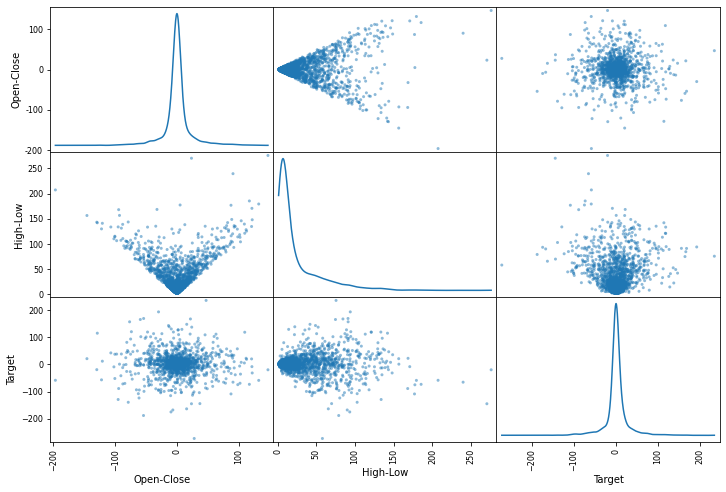

In [9]:
pd.plotting.scatter_matrix(df[['Open-Close', 'High-Low', 'Target']], 
                           grid=True, diagonal='kde', figsize=(12,8))

### Create the train set and test set for the models

In [10]:
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

In [11]:
#Apply OLS model
from sklearn import linear_model
ols = linear_model.LinearRegression() 
ols.fit(X_train, Y_train)

print('OLS Intrecept:', ols.intercept_)
print('OLS Coefficients:', ols.coef_)

from sklearn.metrics import mean_squared_error, r2_score
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_train, ols.predict(X_train)))
      
# Explained variance score: 1 is perfect prediction 
print('Variance score: %.2f' %  r2_score(Y_train, ols.predict(X_train)))

OLS Intrecept: 0.7905675122899131
OLS Coefficients: [ 0.00944674 -0.00660753]
Mean squared error: 243.99
Variance score: 0.00


### Test

In [12]:
###############
#Test 
#
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test[:-1], ols.predict(X_test)[:-1]))  # all but the last data point


#
# Explained variance score: 1 is perfect prediction 
print('Variance score: %.2f' % r2_score(Y_test[:-1], ols.predict(X_test)[:-1]))

Mean squared error: 2833.07
Variance score: -0.00


# Let's use it to predict prices and calculate strategy returns
### We use log returns

In [13]:

df['Predicted_Chg'] = ols.predict(X)

#continuosly compunded return for the day
df['Returns'] = np.log(df['Close'] /df['Close'].shift(1))
df[len(X_train):len(X_train)+10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,Target,Predicted_Chg,Returns
Date,,,,,,,,,,,
2019-08-08,1806.000000,1834.260010,1798.109985,1832.890015,1832.890015,3701200,-26.890015,36.150024,-25.310059,0.297682,0.021781
2019-08-09,1828.949951,1831.089966,1802.219971,1807.579956,1807.579956,2879800,21.369995,28.869995,-22.659912,0.801685,-0.013905
2019-08-12,1795.989990,1800.979980,1777.000000,1784.920044,1784.920044,2905500,11.069946,23.979980,39.419922,0.736694,-0.012615
2019-08-13,1783.000000,1831.739990,1780.000000,1824.339966,1824.339966,3994000,-41.339966,51.739990,-61.380005,0.058166,0.021845
2019-08-14,1793.010010,1795.650024,1757.219971,1762.959961,1762.959961,4893600,30.050049,38.430054,13.160034,0.820515,-0.034224
2019-08-15,1781.989990,1788.000000,1761.959961,1776.119995,1776.119995,3759100,5.869995,26.040039,16.449951,0.673959,0.007437
2019-08-16,1792.890015,1802.910034,1784.550049,1792.569946,1792.569946,3018000,0.320068,18.359985,23.550049,0.672277,0.009219
2019-08-19,1818.079956,1826.000000,1812.609985,1816.119995,1816.119995,2816300,1.959961,13.390015,-14.739990,0.720608,0.013052
2019-08-20,1814.500000,1816.819946,1799.880005,1801.380005,1801.380005,1929500,13.119995,16.939941,22.160034,0.802578,-0.008149


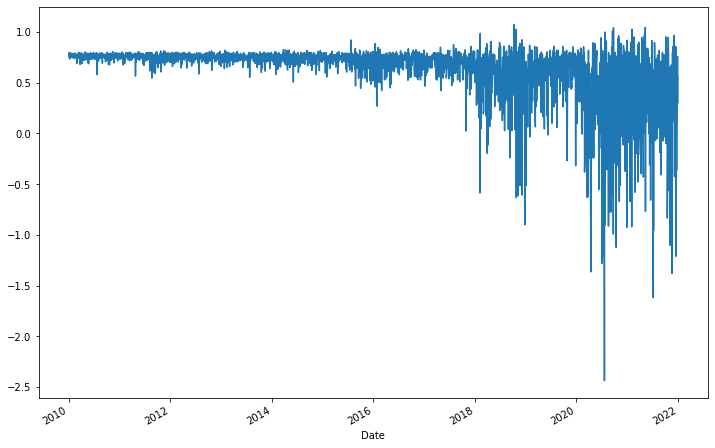

In [14]:
df['Predicted_Chg'].plot(figsize=(12,8))

## Use the Predicted Signal as a strategy
- Buy if the value positive
- Sell if the value negative


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Cumulative return:
 63.49510845145133
Cumulative strategy_return:
 8.578675542430938
Sharpe ratio:' -4.921554890184778


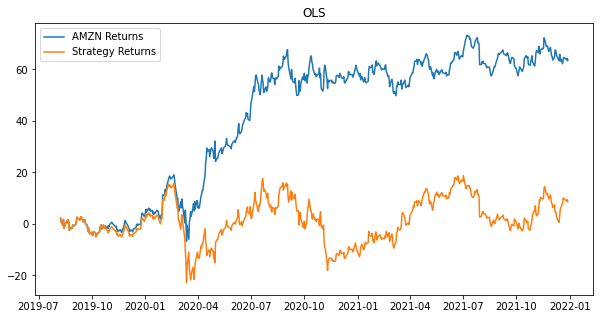

In [15]:

def calculate_return(df, split_value, symbol):
    cum_return = df[split_value:]['Returns'].cumsum() * 100
    df['Strategy_Returns'] = df['Returns'] * np.sign(df['Predicted_Chg'].shift(1))
    return cum_return


def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_return = calculate_return(df,split_value=len(X_train), symbol=ticker)
cum_strategy_return = calculate_strategy_return(df,split_value=len(X_train), symbol=ticker)
def plot_chart(cum_symbol_return, cum_strategy_return, symbol, method):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.title('%s' % method)
    plt.legend()
def sharpe_ratio(strategy_returns,symbol_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()
    
plot_chart(cum_return, cum_strategy_return, symbol=ticker, method='OLS')

print('Cumulative return:\n', cum_return[-1])
print('Cumulative strategy_return:\n', cum_strategy_return[-1])
print('Sharpe ratio:\'', sharpe_ratio(cum_strategy_return, cum_return))

# OLS with Regularization and Shrinkage

# LASSO

In [16]:
#Apply LASSO

#Create the response variable and split the data into training (80%) & test (20%)
def create_classification_trading_condition(data):
    data['Open-Close']=data.Open-data.Close
    data['High-Low']=data.High-data.Low
    data=data.dropna()
    X=data[['Open-Close', 'High-Low']]
    Y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
    return (data, X, Y)
def create_regression_trading_condition(data):
    data['Open-Close']=data.Open-data.Close
    data['High-Low']=data.High-data.Low
    data['Target']=data['Close'].shift(-1)-data['Close']
    data=data.dropna()
    X=data[['Open-Close',  'High-Low']]
    Y = data['Target'] 
    return (data, X, Y)

from sklearn.model_selection import train_test_split
def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

df,X,Y=create_regression_trading_condition(df)
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)


from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1) 
lasso.fit(X_train, Y_train)

print('LASSO Intrecept:', lasso.intercept_)
print('LASSO Coefficients:', lasso.coef_)

from sklearn.metrics import mean_squared_error, r2_score
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_train, lasso.predict(X_train)))
      
# Explained variance score: 1 is perfect prediction 
print('Variance score: %.2f' %  r2_score(Y_train, lasso.predict(X_train)))

LASSO Intrecept: 0.7961608700325242
LASSO Coefficients: [ 0.01108134 -0.00825764]
Mean squared error: 243.55
Variance score: 0.00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

Cumulative return:
 64.66535493325955
Cumulative strategy_return:
 35.36596643784642
Sharpe ratio:' -1.7316726104220583


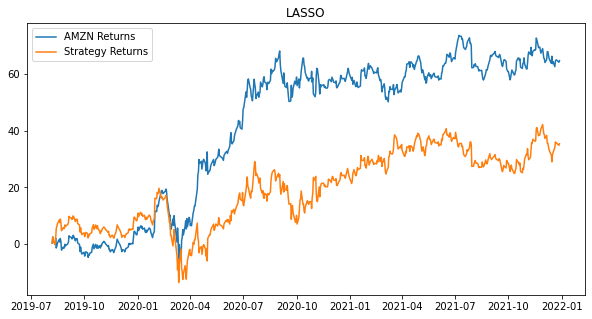

In [17]:
df['Predicted_Chg'] = lasso.predict(X)

#continuosly compunded return for the day
df['Returns'] = np.log(df['Close'] /df['Close'].shift(1))

def calculate_return(df, split_value, symbol):
    cum_return = df[split_value:]['Returns'].cumsum() * 100
    df['Strategy_Returns'] = df['Returns'] * np.sign(df['Predicted_Chg'].shift(1))
    return cum_return


def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_return = calculate_return(df,split_value=len(X_train), symbol=ticker)
cum_strategy_return = calculate_strategy_return(df,split_value=len(X_train), symbol=ticker)
def plot_chart(cum_symbol_return, cum_strategy_return, symbol, method):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.title('%s' % method)
    plt.legend()
def sharpe_ratio(strategy_returns,symbol_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()
    
plot_chart(cum_return, cum_strategy_return, symbol=ticker, method='LASSO')

print('Cumulative return:\n', cum_return[-1])
print('Cumulative strategy_return:\n', cum_strategy_return[-1])
print('Sharpe ratio:\'', sharpe_ratio(cum_strategy_return, cum_return))

# Ridge

In [18]:

#Create the response variable and split the data into training (80%) & test (20%)
def create_classification_trading_condition(data):
    data['Open-Close']=data.Open-data.Close
    data['High-Low']=data.High-data.Low
    data=data.dropna()
    X=data[['Open-Close', 'High-Low']]
    Y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
    return (data, X, Y)
def create_regression_trading_condition(data):
    data['Open-Close']=data.Open-data.Close
    data['High-Low']=data.High-data.Low
    data['Target']=data['Close'].shift(-1)-data['Close']
    data=data.dropna()
    X=data[['Open-Close',  'High-Low']]
    Y = data['Target'] 
    return (data, X, Y)

from sklearn.model_selection import train_test_split
def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

df,X,Y=create_regression_trading_condition(df)
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

from sklearn.metrics import accuracy_score
from sklearn import linear_model
ridge = linear_model.Ridge(alpha=10000) 
ridge.fit(X_train, Y_train)

print('Ridge Intrecept:', ridge.intercept_)
print('Ridge Coefficients:', ridge.coef_)

from sklearn.metrics import mean_squared_error, r2_score
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_train, ridge.predict(X_train)))
      
# Explained variance score: 1 is perfect prediction 
print('Variance score: %.2f' %  r2_score(Y_train, ridge.predict(X_train)))

Ridge Intrecept: 0.8021624365104644
Ridge Coefficients: [ 0.01145616 -0.00861158]
Mean squared error: 243.65
Variance score: 0.00


Cumulative return:
 64.08268207181625
Cumulative strategy_return:
 43.208552157982915
Sharpe ratio:' -0.9180487009909015


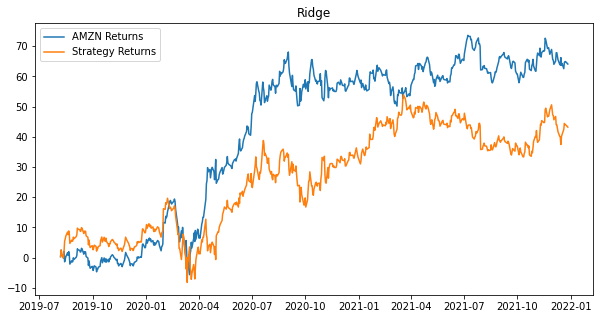

In [19]:
df['Predicted_Chg'] = ridge.predict(X)

#continuosly compunded return for the day
df['Returns'] = np.log(df['Close'] /df['Close'].shift(1))

def calculate_return(df, split_value, symbol):
    cum_return = df[split_value:]['Returns'].cumsum() * 100
    df['Strategy_Returns'] = df['Returns'] * np.sign(df['Predicted_Chg'].shift(1))
    return cum_return


def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_return = calculate_return(df,split_value=len(X_train), symbol=ticker)
cum_strategy_return = calculate_strategy_return(df,split_value=len(X_train), symbol=ticker)
def plot_chart(cum_symbol_return, cum_strategy_return, symbol, method):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.title('%s' % method)
    plt.legend()
def sharpe_ratio(strategy_returns,symbol_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()
    
plot_chart(cum_return, cum_strategy_return, symbol=ticker, method='Ridge')

print('Cumulative return:\n', cum_return[-1])
print('Cumulative strategy_return:\n', cum_strategy_return[-1])
print('Sharpe ratio:\'', sharpe_ratio(cum_strategy_return, cum_return))

# Decision Tree: KNN
### We use price change direction as target variable

In [20]:
#Create the response variable and split the data into training (80%) & test (20%)
def create_classification_trading_condition(data):
    data['Open-Close']=data.Open-data.Close
    data['High-Low']=data.High-data.Low
    data=data.dropna()
    X=data[['Open-Close', 'High-Low']]
    Y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
    return (data, X, Y)
def create_regression_trading_condition(data):
    data['Open-Close']=data.Open-data.Close
    data['High-Low']=data.High-data.Low
    data['Target']=data['Close'].shift(-1)-data['Close']
    data=data.dropna()
    X=data[['Open-Close',  'High-Low']]
    Y = data['Target'] 
    return (data, X, Y)

from sklearn.model_selection import train_test_split
def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

df,X,Y=create_classification_trading_condition(df)
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn=KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print('Accuracy Train: ', accuracy_train)
print('Accuracy Test: ',  accuracy_test)

Accuracy Train:  0.6109498133554542
Accuracy Test:  0.5008291873963516


Cumulative return:
 64.08268207181625
Cumulative strategy_return:
 -46.758449116520026
Sharpe ratio:' -3.353298050141564


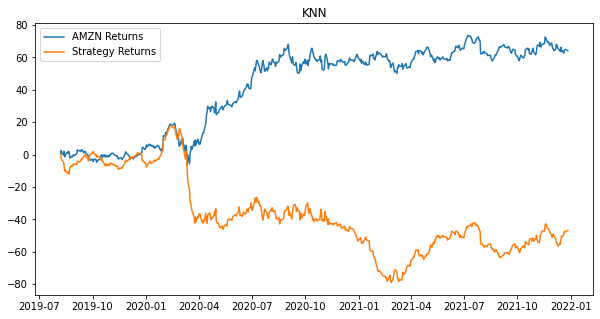

In [21]:

df['Predicted_Chg'] = knn.predict(X)

#continuosly compunded return for the day
df['Returns'] = np.log(df['Close'] /df['Close'].shift(1))

def calculate_return(df, split_value, symbol):
    cum_return = df[split_value:]['Returns'].cumsum() * 100
    df['Strategy_Returns'] = df['Returns'] * np.sign(df['Predicted_Chg'].shift(1))
    return cum_return

def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_return = calculate_return(df,split_value=len(X_train), symbol=ticker)
cum_strategy_return = calculate_strategy_return(df,split_value=len(X_train), symbol=ticker)
def plot_chart(cum_symbol_return, cum_strategy_return, symbol, method):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.title('%s' % method)
    plt.legend()
def sharpe_ratio(strategy_returns,symbol_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()
    
plot_chart(cum_return, cum_strategy_return, symbol=ticker, method='KNN')

print('Cumulative return:\n', cum_return[-1])
print('Cumulative strategy_return:\n', cum_strategy_return[-1])
print('Sharpe ratio:\'', sharpe_ratio(cum_strategy_return, cum_return))

# Support vector machine

In [22]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

!pip install yfinance
import yfinance as yf

start_date = '2010-01-01'
end_date = '2021-12-31'
ticker='AMZN'
df = yf.download(ticker, start_date, end_date)
#Create the response variable and split the data into training (80%) & test (20%)
def create_classification_trading_condition(data):
    data['Open-Close']=data.Open-data.Close
    data['High-Low']=data.High-data.Low
    data=data.dropna()
    X=data[['Open-Close', 'High-Low']]
    Y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
    return (data, X, Y)
def create_regression_trading_condition(data):
    data['Open-Close']=data.Open-data.Close
    data['High-Low']=data.High-data.Low
    data['Target']=data['Close'].shift(-1)-data['Close']
    data=data.dropna()
    X=data[['Open-Close',  'High-Low']]
    Y = data['Target'] 
    return (data, X, Y)

from sklearn.model_selection import train_test_split
def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

amazon_daily,X,Y=create_classification_trading_condition(df)
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)


from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

svc=SVC()
svc.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, svc.predict(X_train))
accuracy_test = accuracy_score(Y_test, svc.predict(X_test))

print('Accuracy Train: ', accuracy_train)
print('Accuracy Test: ',  accuracy_test)

[*********************100%***********************]  1 of 1 completed
Accuracy Train:  0.5384933774834437
Accuracy Test:  0.49337748344370863


Cumulative return:
 60.98759476431863
Cumulative strategy_return:
 -70.440818784577
Sharpe ratio:' -2.4220812329014625


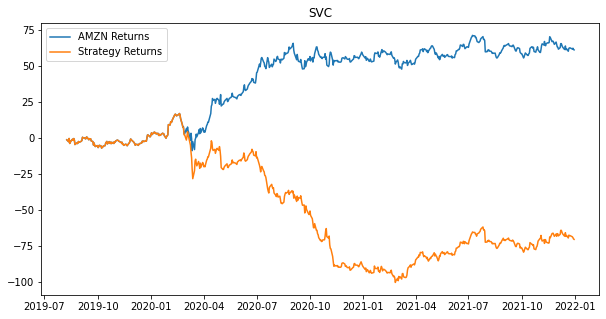

In [23]:
df['Predicted_Chg'] = svc.predict(X)

#continuosly compunded return for the day
df['Returns'] = np.log(df['Close'] /df['Close'].shift(1))

def calculate_return(df, split_value, symbol):
    cum_return = df[split_value:]['Returns'].cumsum() * 100
    df['Strategy_Returns'] = df['Returns'] * np.sign(df['Predicted_Chg'].shift(1))
    return cum_return

def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_return = calculate_return(df,split_value=len(X_train), symbol=ticker)
cum_strategy_return = calculate_strategy_return(df,split_value=len(X_train), symbol=ticker)
def plot_chart(cum_symbol_return, cum_strategy_return, symbol, method):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.title('%s' % method)
    plt.legend()
def sharpe_ratio(strategy_returns,symbol_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()
    
plot_chart(cum_return, cum_strategy_return, symbol=ticker, method='SVC')

print('Cumulative return:\n', cum_return[-1])
print('Cumulative strategy_return:\n', cum_strategy_return[-1])
print('Sharpe ratio:\'', sharpe_ratio(cum_strategy_return, cum_return))

# Logistic regression

In [24]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

!pip install yfinance
import yfinance as yf

start_date = '2010-01-01'
end_date = '2021-12-31'
ticker='AMZN'
df = yf.download(ticker, start_date, end_date)


df['Open-Close']=df.Open-df.Close
df['High-Low']=df.High-df.Low
df=df.dropna()
X=df[['Open-Close','High-Low']]
Y=np.where(df['Close'].shift(-1)>df['Close'],1,-1)

split_ratio=0.8
split_value=int(split_ratio * len(df))
X_train=X[:split_value]
Y_train=Y[:split_value]
X_test=X[split_value:]
Y_test=Y[split_value:]


logistic=LogisticRegression()
logistic.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, logistic.predict(X_train))
accuracy_test = accuracy_score(Y_test, logistic.predict(X_test))
print(accuracy_train, accuracy_test)

[*********************100%***********************]  1 of 1 completed
0.5318708609271523 0.5298013245033113


Cumulative return:
 60.98759476431863
Cumulative strategy_return:
 60.98759476431863
Sharpe ratio:' 0.0


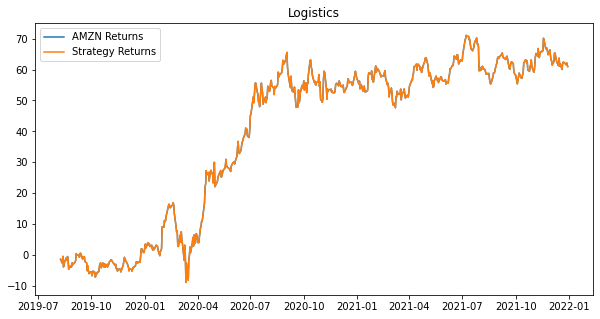

In [25]:
df['Predicted_Chg'] = logistic.predict(X)

#continuosly compunded return for the day
df['Returns'] = np.log(df['Close'] /df['Close'].shift(1))

def calculate_return(df, split_value, symbol):
    cum_return = df[split_value:]['Returns'].cumsum() * 100
    df['Strategy_Returns'] = df['Returns'] * np.sign(df['Predicted_Chg'].shift(1))
    return cum_return

def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_return = calculate_return(df,split_value=len(X_train), symbol=ticker)
cum_strategy_return = calculate_strategy_return(df,split_value=len(X_train), symbol=ticker)
def plot_chart(cum_symbol_return, cum_strategy_return, symbol, method):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.title('%s' % method)
    plt.legend()
def sharpe_ratio(strategy_returns,symbol_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()
    
plot_chart(cum_return, cum_strategy_return, symbol=ticker, method='Logistics')

print('Cumulative return:\n', cum_return[-1])
print('Cumulative strategy_return:\n', cum_strategy_return[-1])
print('Sharpe ratio:\'', sharpe_ratio(cum_strategy_return, cum_return))